In [1]:
#loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
# Load Dataset
train_data = pd.read_csv(".\Google_Stock_Price_Train.csv")
test_data = pd.read_csv(".\Google_Stock_Price_Test.csv")

# Focus on the 'Open' column only
training_set = train_data.iloc[:, 1:2].values 
test_set = test_data.iloc[:, 1:2].values

# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)


In [4]:
# Create Dataset Function
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])  # Input: last 'time_step' Open prices
        y.append(data[i, 0])  # Output: next Open price
    return np.array(X), np.array(y)

# Parameters
time_step = 60

# Prepare Training Data
X_train, y_train = create_dataset(training_set_scaled, time_step)

# Reshape for LSTM Input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [5]:
# Build the LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output Layer: Predict next Open price
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the Model
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/100


C:\Users\Akhila\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0781 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 12/

In [6]:
# Prepare Test Data
dataset_total = np.vstack((training_set, test_set))  # Combine train and test
inputs = dataset_total[len(dataset_total) - len(test_set) - time_step:]
inputs_scaled = scaler.transform(inputs)

X_test = []
for i in range(time_step, len(inputs_scaled)):
    X_test.append(inputs_scaled[i - time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make Predictions
predicted_stock_price = model.predict(X_test)

# Inverse Transform Predictions
predicted_stock_price = scaler.inverse_transform(
    np.concatenate([predicted_stock_price, np.zeros((len(predicted_stock_price), 1))], axis=1)
)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


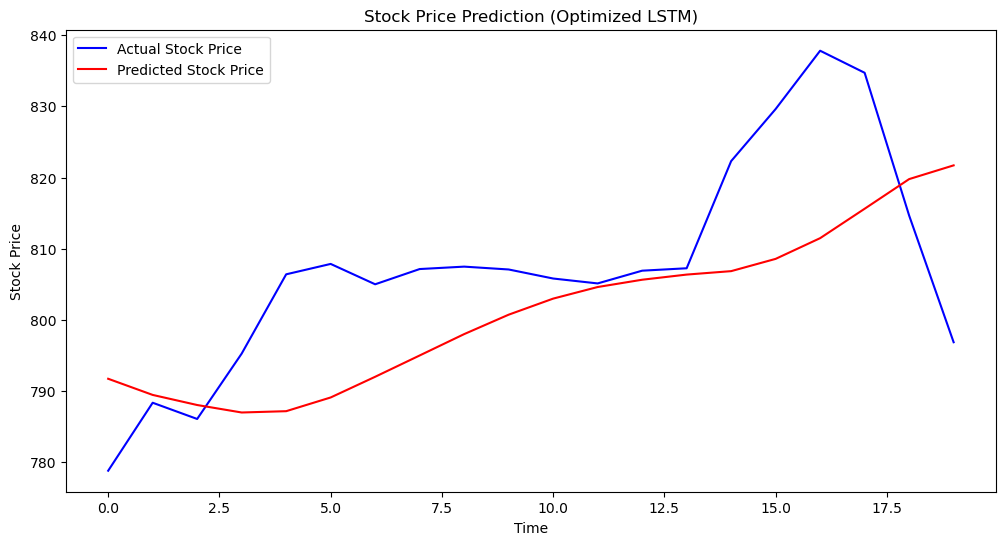

Mean Absolute Error (MAE): 11.0289
R2 Score: 0.1252


In [7]:
# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(test_set, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Optimized LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate Results
mae = mean_absolute_error(test_set, predicted_stock_price)
r2 = r2_score(test_set, predicted_stock_price)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
